Consider the glass fragments data from the book's website.
Let $Y$ be the refractive index and let $X$ be the alumninum content
(the fourth variable).
1. Do a nonparametric regression to fit the model
   $Y = f(x) + \varepsilon$ using the cosine basis method.
   The data are not on a regular grid.
   Ignore this when estimating the function.
   (But do sort the data first according to $X$.)
   Provide a function estimate, an estimate of the risk, and a confidence band.
1. Use the wavelet method to estimate $f$.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats

## Download the glass fragment data

In [3]:
# Read the data into a pandas data frame
df = pd.read_csv('../data/glass_clean.dat', sep='\t')

# Transform the two dataframe columns of interest into an array
# where the first column corresponds to X,
# the second column corresponds to Y, and
# each row corresponds to a sample.
glass_X = df['Al'].to_numpy()
glass_Y = df['RI'].to_numpy()

## The CosineRegression class

In [4]:
class CosineRegression():

    def __init__(self,
        response,
        covariate,
        smoothing_parameter=None,
        x_arr=np.linspace(0, 1, 1000),
        alpha=0.05
    ):
        """
        Initializes a CosineRegression object given two 1D arrays
        response and covariate, as well as optionally given an integer
        smoothing_parameter.
        """

        self.number_of_samples = len(response)
        self.response = response
        self.covariate = covariate
        # Normalize the covariate data, if necessary
        if covariate.min() < 0 or covariate.max() > 1:
            self.covariate_normalized = (
                (covariate - covariate.min())/(covariate.max() - covariate.min())
            )
        else:
            self.covariate_normalized = covariate
        self.smoothing_parameter = smoothing_parameter
        self.coefficients = None
        self.variance_estimate = None
        # The x-values in x_arr must be in [0, 1]
        self.x_arr = x_arr
        self.alpha = alpha
        self.confidence_band = None

    def compute_coefficients(self):
        """
        Computes the empirical cosine basis coefficients 
        estimates given data.

        We compute the basis coefficients up to j = n,
        where n is the number of samples, since all of
        these coefficients are eventually needed when
        estimating the variance or the risk.

        Here we use the normalized version of the covariates.
        """

        # We compute the 2D array Yi cos(j*pi*Xi),
        # indexed by (i, j)
        coefficients_sample = np.einsum(
            'i, ij -> ij',
            self.response,
            np.cos(np.pi*np.outer(
                self.covariate_normalized,
                range(self.number_of_samples + 1)
            ))
        )
    
        # The estimate \hat beta_j is the sample mean
        # of Yi cos(j*pi*xi), which we then multiply
        # by sqrt(2), except when j=0 where we multiply by one.
        coefficients = (
            np.concatenate(([1], np.sqrt(2)*np.ones(self.number_of_samples)))
            *np.mean(coefficients_sample, axis=0)
        )
    
        self.coefficients = coefficients

    def compute_confidence_band(self):
        """
        Compute a 1-alpha confidence band for
        the cosine basis regression estimator
        evaluated at the x-values in self.x_arr.
        
        The x-values in self.x_arr must be in [0, 1].
        """

        # If necessary, compute the variance estimate 
        # and select the smoothing parameter which
        # minimizes the risk estimate.
        if self.variance_estimate is None:
            self.compute_variance_estimate()
        if self.smoothing_parameter is None:
            self.compute_smoothing_parameter_from_risk_estimate()

        # Evaluate the cosine regression estimator
        # at values in x_arr and return the rescaled x-values
        # to be used for plotting as well
        y_arr, x_arr_scaled = self.evaluate()

        # Compute the auxiliary functions used
        # to construct the confidence band
        a_tilde = 1 + (
            2*self.smoothing_parameter
            - 1 + np.sin(
                (2*self.smoothing_parameter + 1)*np.pi*self.x_arr
            )
        )/2
        alpha_quantile = stats.chi2.isf(self.alpha, df=self.smoothing_parameter)
        confidence = np.sqrt((self.variance_estimate*alpha_quantile/self.number_of_samples)*a_tilde)

        # Return the confidence band evaluations as
        # (lower_bound, upper_bound).
        self.confidence_band = (y_arr - confidence, y_arr + confidence)
    
    def compute_smoothing_parameter_from_risk_estimate(self):
        """
        Compute the risk estimate for J = 0, ..., n
        then set smoothing_parameter to the value of J
        that minimizes it.
        """

        # If necessary, compute the cosine basis coefficients
        # and the variance estimate
        if self.coefficients is None:
            self.compute_coefficients()
        if self.variance_estimate is None:
            self.compute_variance_estimate()

        # Compute the bias estimate \hat beta_j^2 - \hat sigma^2 / n for each j
        bias_estimate_j = self.coefficients**2 - self.variance_estimate/self.number_of_samples
        # Take the positive part of the bias estimates
        bias_estimate_j = np.where(bias_estimate_j > 0, bias_estimate_j, 0)
        # Compute the partial sums from j = J+1 to j = n
        # as J runs from 0 to n.
        bias_estimate_partial_sums = np.flip(np.flip(bias_estimate_j).cumsum())

        # Compute the risk estimate for each value of J
        risk_estimate = (
            np.arange(self.number_of_samples + 1)*self.variance_estimate/self.number_of_samples
            + bias_estimate_partial_sums
        )

        # Select the smoothing parameter which minimizes the risk estimate
        self.smoothing_parameter = np.argmin(risk_estimate)

    def compute_variance_estimate(self):
        """
        Estimate the variance of Y - r(X),
        where r denotes the regression function
        r(x) = E(Y | X = x).

        IMPORTANT: This estimate is only valid when
        the covariate data X satisfies 0 < X < 1.
        """

        # Number of final modes to consider
        k = int(np.floor(self.number_of_samples/4))

        # If necesary, compute the cosine basis coefficients
        if self.coefficients is None:
            self.compute_coefficients()

        # Compute the variance estimate
        self.variance_estimate = (self.number_of_samples/k)*np.sum(self.coefficients[-k:]**2)

    def evaluate(self):
        """
        Evaluate the cosine basis regression estimator
        at the x-values of self.x_arr and return both
        the evaluated valaues and the corresponding
        rescaled array in the original units of 
        the covariate data.
        """
        
        y_arr = self.synthesis()
        # The cosine basis coefficients are computed
        # using a normalized version of the covariates
        # rescaled to be in [0, 1]. For the plot to
        # be in the original units of the covariate data
        # we must undo that normalization by rescaling
        # appropriately.
        x_arr_scaled = (
            (self.covariate.max() - self.covariate.min())
            *self.x_arr + self.covariate.min()
        )

        return y_arr, x_arr_scaled

    def plot(self,
         axs=None,
         show_scatter_plot=True,
         plot_confidence_band=True,
         true_regression_function=None
    ):
        """
        Given a matplotlib.pyplot axis object 'axs',
        plot an evaluation of the cosine basis
        regression estimator at the x-values of self.x_arr.
        """

        # If axs is not provided, create it
        if axs is None:
            figure, axs = plt.subplots(1)

        y_arr, x_arr_scaled = self.evaluate()
        axs.plot(x_arr_scaled, y_arr, color='crimson', label='Regression estimator')
        
        # For synthetic data: if the true regression
        # function is provided, plot it as well
        if true_regression_function is not None:
            axs.plot(x_arr_scaled, true_regression_function(x_arr_scaled), label='True regression function')

        # If asked, plot a 1 - alpha confidence band
        if plot_confidence_band:
            # If necesary, compute the confidence band evaluations
            if self.confidence_band is None:
                self.compute_confidence_band()
            lower_bound, upper_bound = self.confidence_band
            axs.fill_between(x_arr_scaled, lower_bound, upper_bound, color='lightsteelblue', label='Confidence band')

        # If asked, show a scatter plot of the original data
        if show_scatter_plot:
            axs.scatter(self.covariate, self.response, color='darkseagreen', alpha=0.3, label='Data')

        axs.legend(loc='best')
    
    def synthesis(self):
        """
        Reconstruct the cosine basis regression estimator
        from its cosine basis coefficients estimates,
        ordered from j = 0 to n, and evaluate that
        estimator at the x-values in self.x_arr.

        The x-values in self.x_arr must be in [0, 1].

        Returns
        y_arr       1D array containing the values of
                    the estimator evaluated at the x-values
                    in x_arr.
        """

        # If necessary, compute the cosine basis coefficients,
        # and select the smoothing parameter which minimizes
        # the risk estimate.
        if self.coefficients is None:
            self.compute_coefficients()
        if self.smoothing_parameter is None:
            self.compute_smoothing_parameter_from_risk_estimate()
        
        j_mesh, x_mesh = np.meshgrid(
            range(1, self.smoothing_parameter + 1),
            self.x_arr,
            indexing='ij'
        )
        coeff_mesh = self.coefficients[j_mesh]
        y_arr = self.coefficients[0] + np.sqrt(2)*np.sum(
            coeff_mesh*np.cos(np.pi*j_mesh*x_mesh),
            axis = 0
        )

        return y_arr

## Cosine regression for the glass fragment data

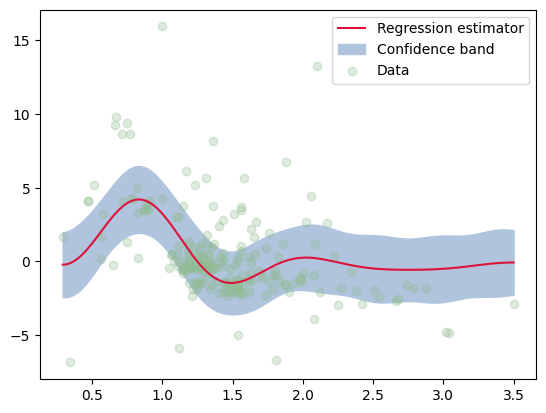

In [5]:
glass_cosine_regression = CosineRegression(glass_Y, glass_X)
glass_cosine_regression.plot()
plt.show()
plt.close()

## Visual sanity check using synthetic data

The variance estimate is 0.297; the true variance is 0.010000000000000002
The variance estimate is 0.00194; the true variance is 0.0001


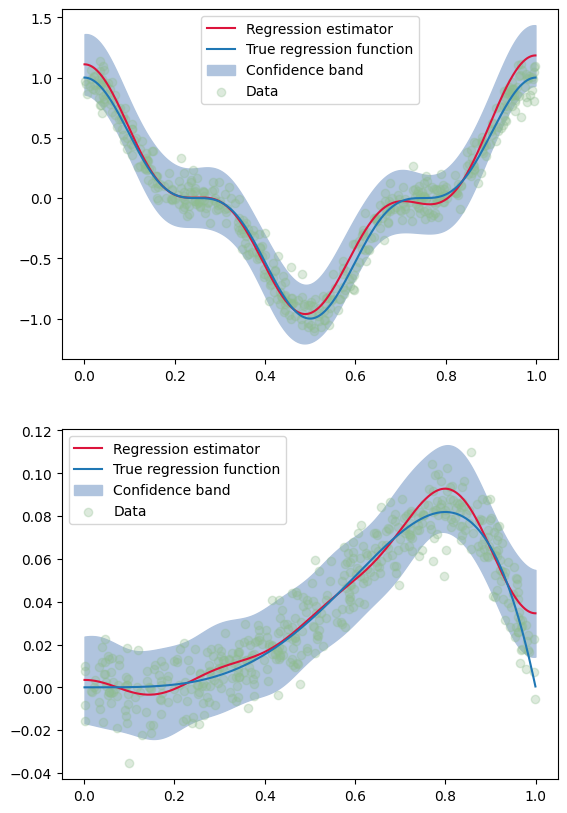

In [6]:
periodic_function = lambda x: np.cos(2*np.pi*x)**3
polynomial_function = lambda x: x*(1-x)*x**3

n = 500

# Perform cosine regression on several synthetic datasets.
# which have different standard deviations for the error
# and underlying true regression functions.
figure, axes = plt.subplots(2)
figure.set_figheight(10)
for axis, (function, error_std) in zip(axes, (
    (periodic_function, 0.1),
    (polynomial_function, 0.01),
)):
    covariate = stats.uniform.rvs(size=n)
    error = stats.norm.rvs(scale=error_std, size=n)
    response = function(covariate) + error
    cosine_regression = CosineRegression(response, covariate)
    cosine_regression.plot(axs=axis, true_regression_function=function)
    print(
        f"The variance estimate is {cosine_regression.variance_estimate:5.3}; "
        f"the true variance is {error_std**2:2}"
    )
plt.show()